In [ ]:
 pip install --user mysql-connector-python


In [5]:
# --- Setup cell ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

# optional: display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)


In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments'),
    ('geolocation.csv', 'geolocation')
]

# MySQL connection
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='rkop1sk5',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing CSV files
folder_path = 'C:/Users/Sys/Desktop/ecommerce'

# Map pandas dtype to MySQL type
def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    # Read CSV
    df = pd.read_csv(file_path)

    if df.empty:
        print(f"{csv_file} is empty, skipping.")
        continue

    # Replace NaN with None
    df = df.where(pd.notnull(df), None)

    # Clean column names
    df.columns = [col.strip().replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Create table
    columns_def = ', '.join([f"`{col}` {get_sql_type(df[col].dtype)}" for col in df.columns])
    create_table_query = f"CREATE TABLE IF NOT EXISTS `{table_name}` ({columns_def})"
    cursor.execute(create_table_query)
    print(f"Table `{table_name}` created or exists.")

    # Prepare insert query with backticks
    columns_list = ', '.join([f"`{col}`" for col in df.columns])
    placeholders = ', '.join(['%s'] * len(df.columns))
    insert_sql = f"INSERT INTO `{table_name}` ({columns_list}) VALUES ({placeholders})"

    # Insert rows
    for _, row in df.iterrows():
        values = tuple(None if pd.isna(x) else x for x in row)
        cursor.execute(insert_sql, values)

    conn.commit()
    print(f"{len(df)} rows inserted into `{table_name}`.\n")

conn.close()
print("All CSV files processed and MySQL connection closed.")


File not found: C:/Users/Sys/Desktop/ecommerce\customers.csv
File not found: C:/Users/Sys/Desktop/ecommerce\orders.csv
Table `sellers` created or exists.
3095 rows inserted into `sellers`.

File not found: C:/Users/Sys/Desktop/ecommerce\products.csv
Table `order_items` created or exists.


In [43]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
db = mysql.connector.connect(host ="localhost",
                             username = "root",
                             password ="rkop1sk5",
                             database = "ecommerce")
cur = db.cursor()

In [74]:
#1. List all unique cities where customers are located.
query = """ select distinct customer_city from customers """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["CITIES"])
df

,CITIES
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


In [37]:
#2. Count the number of orders placed in 2017.
query ="""select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
" Total number of orders placed in 2017:", data[0][0]

(' Total number of orders placed in 2017:', 90202)

In [51]:
#3. Find the total sales per category.
query ="""select upper(products.product_category) as category, round(sum(payments.payment_value),2) sales from products join order_items
on products.product_id = order_items.product_id join payments on payments.order_id = order_items.order_id group by category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["category","sales"])
df.

,category,sales
0,PERFUMERY,16215637.12
1,FURNITURE DECORATION,45765644.54
2,TELEPHONY,15580225.62
3,BED TABLE BATH,54801717.47
4,AUTOMOTIVE,27273418.60
...,...,...
69,CDS MUSIC DVDS,38381.76
70,LA CUISINE,93232.96
71,FASHION CHILDREN'S CLOTHING,25141.44
72,PC GAMER,69581.76


In [68]:
#4. Calculate the percentage of orders that were paid in installments
query =""" select (sum(case when payment_installments >=1 then 1 else 0 end))/count(*)*100 from payments"""
cur.execute(query)
data = cur.fetchall()
"Percentage of orders that were paid in installments:", data[0][0]

('Percentage of orders that were paid in installments:', Decimal('99.9981'))

<function matplotlib.pyplot.show(close=None, block=None)>

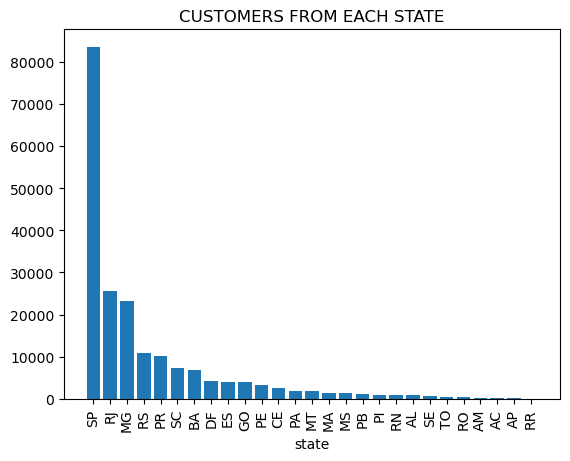

<Figure size 900x1000 with 0 Axes>

In [70]:
#5. Count the number of customers from each state.
query ="""select customer_state,count(customer_id) from customers group by customer_State"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state","customer_count"])
df = df.sort_values(by="customer_count",ascending = False)
plt.bar(df["state"],df["customer_count"])
plt.title("CUSTOMERS FROM EACH STATE")
plt.xlabel("state")
plt.xticks(rotation = 90)
plt.figure(figsize =(9,10))
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

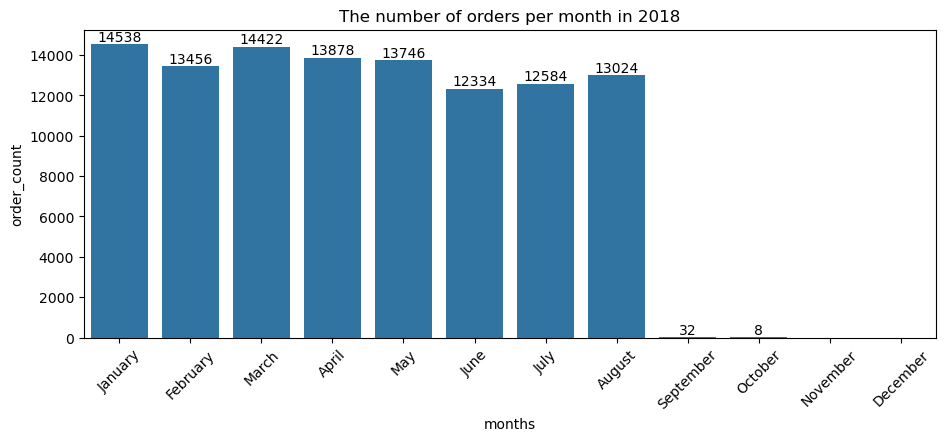

In [22]:
 #6. Calculate the number of orders per month in 2018.
query = """ SELECT MONTHNAME(order_purchase_timestamp) AS months,
       COUNT(order_id) AS `order_count`
FROM orders
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY months;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["months","order_count"])
o = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
plt.figure(figsize =(11,4))
ax = sns.barplot(x= df["months"],y= df["order_count"], data = df, order = o)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("The number of orders per month in 2018")
plt.show



In [22]:
#7.Find the average number of products per order, grouped by customer city.
query =  """WITH count_per_order AS (
    SELECT 
        orders.order_id, 
        orders.customer_id, 
        COUNT(order_items.order_id) AS oc
    FROM orders
    JOIN order_items 
        ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)
SELECT 
    customers.customer_city, 
    ROUND(AVG(count_per_order.oc), 2) AS average_orders
FROM customers
JOIN count_per_order 
    ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city;"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["city","average order"])
df.head()

,city,average order
0,sao paulo,11.56
1,sao jose dos campos,11.38
2,porto alegre,11.75
3,indaial,11.15
4,treze tilias,12.73


In [37]:
#Calculate the percentage of total revenue contributed by each product category.
query = """SELECT 
    UPPER(products.product_category) AS category,
    ROUND((SUM(payments.payment_value)/(SELECT SUM(payment_value) FROM payments))*100, 2) AS sales_percentage
FROM products
JOIN order_items 
    ON products.product_id = order_items.product_id
JOIN payments 
    ON payments.order_id = order_items.order_id
GROUP BY category
ORDER BY sales_percentage DESC"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["category","percentage"])
df.head()


,category,percentage
0,BED TABLE BATH,106.98
1,HEALTH BEAUTY,103.53
2,COMPUTER ACCESSORIES,99.03
3,FURNITURE DECORATION,89.34
4,WATCHES PRESENT,89.28


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

THE CORRELATION BETWEEN NUMBER OF PRICE AND the number of times a product has been purchased IS -0.10631514167157564


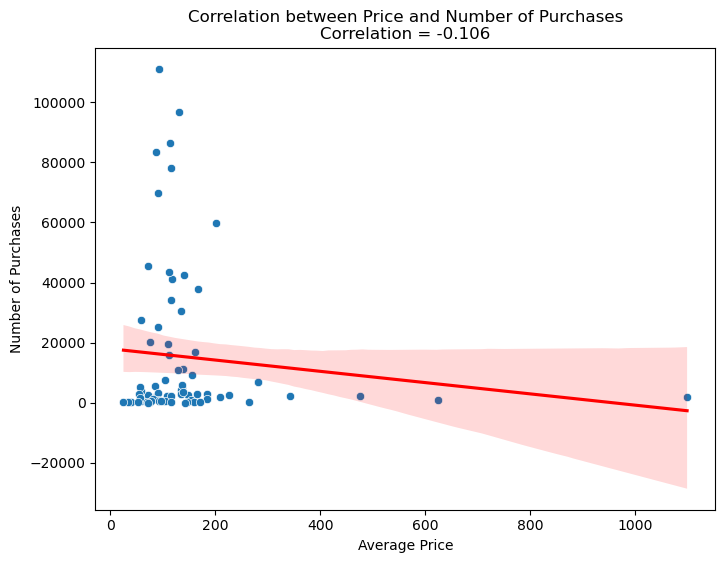

In [55]:
#9. Identify the correlation between product price and the number of times a product has been purchased.
query = """SELECT 
products.product_category,COUNT(order_items.product_id) AS total_products, ROUND(AVG(order_items.price), 2) AS average_price
FROM 
    products
JOIN 
    order_items 
ON 
    products.product_id =order_items.product_id
GROUP BY 
    products.product_category;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["product_category","total_products","average_price"])
array1 = df["total_products"]
array2 = df["average_price"]
a = np.corrcoef([array1,array2])
print(f"THE CORRELATION BETWEEN NUMBER OF PRICE AND the number of times a product has been purchased IS {a[0][1]}")
plt.figure(figsize=(8,6))
sns.scatterplot(x='average_price', y='total_products', data=df)
sns.regplot(x='average_price', y='total_products', data=df, scatter=False, color='red')
plt.title(f'Correlation between Price and Number of Purchases\nCorrelation = {a[0][1]:.3f}')
plt.xlabel('Average Price')
plt.ylabel('Number of Purchases')
plt.show()

In [71]:
#10.Calculate the total revenue generated by each seller, and rank them by revenue. 

query =  """select * , dense_rank() over (order by revenue desc) as rnk from (select order_items.seller_id,
round(sum(payments.payment_value),2) revenue from order_items join payments
 on order_items.order_id = payments.order_id
 group by order_items.seller_id)as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["seller_id","revenue","Rank"])
df



,seller_id,revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,12679172.68,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,7705551.00,2
2,4a3ca9315b744ce9f8e9374361493884,7531131.74,3
3,1f50f920176fa81dab994f9023523100,7256335.50,4
4,53243585a1d6dc2643021fd1853d8905,7122577.01,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,480.25,3076
3091,702835e4b785b67a084280efca355756,464.00,3077
3092,4965a7002cca77301c82d3f91b82e1a9,409.00,3078
3093,77128dec4bec4878c37ab7d6169d6f26,380.50,3079


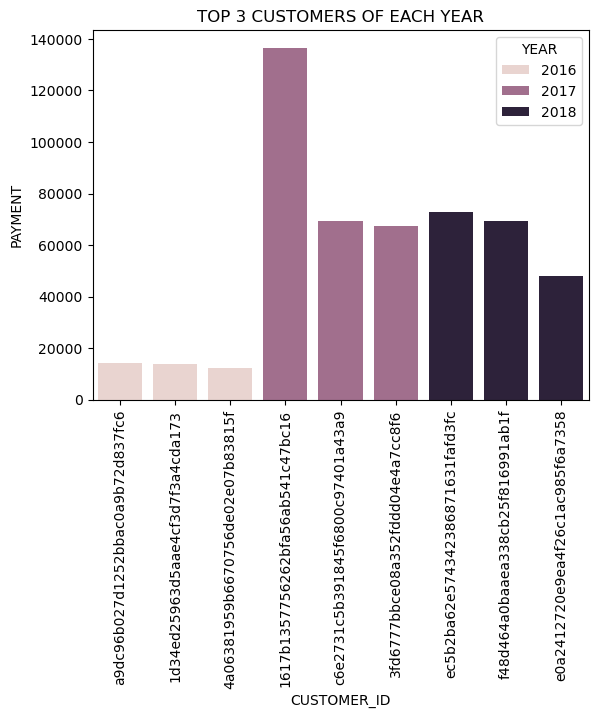

In [67]:
#11. Identify the top 3 customers who spent the most money in each year.
query = """Select year,customer_id, payment,rnk from
(SELECT year(orders.order_purchase_timestamp) year ,orders.customer_id,sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) rnk 
from orders  
join payments on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp),orders.customer_id) as a
where rnk <=3"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["YEAR","CUSTOMER_ID","PAYMENT","RANK"])
sns.barplot(y= "PAYMENT", x= "CUSTOMER_ID",hue = "YEAR",data = df)
plt.xticks(rotation = 90)
plt.title("TOP 3 CUSTOMERS OF EACH YEAR")
plt.show()